In [1]:
!pip install datasets transformers scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.0 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path = "/content/drive/MyDrive/w266/Project/expanded_stock.csv"
df = pd.read_csv(data_path, parse_dates=['timestamp'])

In [6]:
target_tickers = ['$AAPL', '$MSFT', '$AMD', '$NVDA', '$AMZN']
df = df[df['ticker'].isin(target_tickers)].copy()

# Clean sentiment
def clean_sentiment(s):
    if isinstance(s, str):
        s = s.strip().lower()
        if "bullish" in s:
            return "BULLISH"
        elif "bearish" in s:
            return "BEARISH"
        elif "neutral" in s:
            return "NEUTRAL"
    return None

df['sentiment_clean'] = df['sentiment'].apply(clean_sentiment)
df = df.dropna(subset=['sentiment_clean'])

# Map sentiment to labels: BEARISH=0, NEUTRAL=1, BULLISH=2
sentiment_mapping = {"BEARISH": 0, "NEUTRAL": 1, "BULLISH": 2}
df['label'] = df['sentiment_clean'].map(sentiment_mapping)

print("Label distribution:")
print(df['label'].value_counts())

# Rename text column for consistency
df = df.rename(columns={'description': 'text'})
df = df[['text', 'label']].reset_index(drop=True)

Label distribution:
label
2    1289
1     433
0     402
Name: count, dtype: int64


<ipython-input-6-8d1d3e05b135>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['sentiment_clean'].map(sentiment_mapping)


In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print("Train size:", len(train_df), "Validation size:", len(val_df))

Train size: 1699 Validation size: 425


In [8]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

In [14]:
def fine_tune_bert(
    model_name,
    output_dir,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_batch_size=16,
    dropout=None,
    warmup_steps=None,
    max_grad_norm=None,
    weight_decay=0.01  # <-- added default parameter
):
    print(f"\nFine-tuning model {model_name} with epochs={num_train_epochs}, lr={learning_rate}, "
          f"batch_size={per_device_batch_size}, dropout={dropout}, warmup_steps={warmup_steps}, "
          f"max_grad_norm={max_grad_norm}, weight_decay={weight_decay}")

    # Load tokenizer and model
    tokenizer = BertTokenizerFast.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

    if dropout is not None:
        model.config.hidden_dropout_prob = dropout
        model.config.attention_probs_dropout_prob = dropout

    def tokenize_function(example):
        return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

    tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(["text", "__index_level_0__"])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    # Set up TrainingArguments using the given weight_decay
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_batch_size,
        per_device_eval_batch_size=per_device_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir=f"{output_dir}/logs",
        logging_steps=50,
        warmup_steps=warmup_steps if warmup_steps is not None else 0,
        max_grad_norm=max_grad_norm if max_grad_norm is not None else 1.0,
    )

    # Define metric computation (accuracy)
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        acc = accuracy_score(labels, predictions)
        return {"accuracy": acc}

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    eval_results = trainer.evaluate()
    print(f"Evaluation results for {model_name}:", eval_results)

    # Save model and tokenizer
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

    return trainer, eval_results


In [10]:
# import optuna

# def model_init():
#     return BertForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     accuracy = (predictions == labels).astype(np.float32).mean().item()
#     return {"accuracy": accuracy}

# def hp_space(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
#         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
#         "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 5),
#         "warmup_steps": trial.suggest_int("warmup_steps", 0, 500, step=100),
#     }

In [11]:
# training_args = TrainingArguments(
#     output_dir="./finetuned_optuna",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     logging_strategy="epoch",
#     disable_tqdm=False,
#     logging_steps=50,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     num_train_epochs=3,
# )

In [46]:
# tokenizer = BertTokenizerFast.from_pretrained("ProsusAI/finbert")
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [49]:
# # tokenization function
# def tokenize_function(example):
#     return tokenizer(
#         example["text"],
#         truncation=True,
#         padding="max_length",
#         max_length=128
#     )

#LOT OF ISSUES GOING HERE PLEASE FIX
# tokenized_dataset = dataset_dict.map(tokenize_function, batched=True)

# tokenized_dataset = tokenized_dataset.remove_columns(["text"])
# tokenized_dataset.set_format("torch")


Map:   0%|          | 0/1699 [00:00<?, ? examples/s]

Map:   0%|          | 0/425 [00:00<?, ? examples/s]

In [50]:
# trainer = Trainer(
#     model_init=model_init,
#     args=training_args,
#     train_dataset=tokenized_dataset["train"],
#     eval_dataset=tokenized_dataset["validation"],
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )


<ipython-input-50-754118308492>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [51]:
# best_trial = trainer.hyperparameter_search(
#     direction="maximize",
#     hp_space=hp_space,
#     n_trials=10,   # Try 10 trials (adjust accordingly)
#     backend="optuna",
# )

[I 2025-04-13 17:49:59,885] A new study created in memory with name: no-name-0cdb86f7-e4f7-4947-b995-8aab5a8d601d


Epoch,Training Loss,Validation Loss,Accuracy
1,1.207300,0.938826,0.600000
2,0.865900,0.854350,0.637647
3,0.780100,0.834818,0.640000
4,0.630500,0.822038,0.656471


[I 2025-04-13 17:53:18,111] Trial 0 finished with value: 0.6564705967903137 and parameters: {'learning_rate': 1.433308520774491e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'warmup_steps': 400}. Best is trial 0 with value: 0.6564705967903137.


eval/accuracy,▁▆▆█
eval/loss,█▃▂▁
eval/runtime,█▅▁▂
eval/samples_per_second,▁▄█▇
eval/steps_per_second,▁▄█▇
train/epoch,▁▁▃▃▆▆███
train/global_step,▁▁▃▃▆▆███
train/grad_norm,▂▁█▂
train/learning_rate,▃▆█▁
train/loss,█▄▃▁
eval/accuracy,0.65647


Epoch,Training Loss,Validation Loss,Accuracy
1,1.159200,0.902317,0.618824
2,0.846400,0.859318,0.642353
3,0.749300,0.837057,0.647059
4,0.577500,0.821370,0.663529
5,0.384100,1.025670,0.647059


[I 2025-04-13 17:57:21,021] Trial 1 finished with value: 0.6470588445663452 and parameters: {'learning_rate': 2.4889769631691895e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'warmup_steps': 500}. Best is trial 0 with value: 0.6564705967903137.


eval/accuracy,▁▅▅█▅
eval/loss,▄▂▂▁█
eval/runtime,█▁▂▂▁
eval/samples_per_second,▁█▇▇█
eval/steps_per_second,▁█▇▇█
train/epoch,▁▁▃▃▅▅▆▆███
train/global_step,▁▁▃▃▄▄▆▆███
train/grad_norm,▂▂█▂▁
train/learning_rate,▃▅▆█▁
train/loss,█▅▄▃▁
eval/accuracy,0.64706


Epoch,Training Loss,Validation Loss,Accuracy
1,1.107400,0.876728,0.616471
2,0.823500,0.857155,0.647059
3,0.695700,0.813086,0.663529


[I 2025-04-13 17:59:42,710] Trial 2 finished with value: 0.6635293960571289 and parameters: {'learning_rate': 2.9625151093602377e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'warmup_steps': 400}. Best is trial 2 with value: 0.6635293960571289.


eval/accuracy,▁▆█
eval/loss,█▆▁
eval/runtime,█▁▂
eval/samples_per_second,▁█▆
eval/steps_per_second,▁█▆
train/epoch,▁▁▅▅███
train/global_step,▁▁▄▄███
train/grad_norm,▁▁█
train/learning_rate,▁▄█
train/loss,█▃▁
eval/accuracy,0.66353


Epoch,Training Loss,Validation Loss,Accuracy
1,1.038000,0.849869,0.642353
2,0.783700,0.795536,0.675294
3,0.528400,0.885375,0.672941


[I 2025-04-13 18:02:29,794] Trial 3 finished with value: 0.6729411482810974 and parameters: {'learning_rate': 2.3637663875749432e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'warmup_steps': 400}. Best is trial 3 with value: 0.6729411482810974.


eval/accuracy,▁█▇
eval/loss,▅▁█
eval/runtime,▁█▇
eval/samples_per_second,█▁▂
eval/steps_per_second,█▁▂
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/grad_norm,▁▃█
train/learning_rate,▅█▁
train/loss,█▅▁
eval/accuracy,0.67294


Epoch,Training Loss,Validation Loss,Accuracy
1,0.898300,0.809025,0.656471
2,0.656600,0.766899,0.703529
3,0.372900,0.911634,0.682353
4,0.184200,1.108135,0.684706


[I 2025-04-13 18:06:15,775] Trial 4 finished with value: 0.6847058534622192 and parameters: {'learning_rate': 2.828586352769539e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'warmup_steps': 0}. Best is trial 4 with value: 0.6847058534622192.


eval/accuracy,▁█▅▅
eval/loss,▂▁▄█
eval/runtime,█▁▂▄
eval/samples_per_second,▁█▇▅
eval/steps_per_second,▁█▇▅
train/epoch,▁▁▃▃▆▆███
train/global_step,▁▁▃▃▆▆███
train/grad_norm,▁▂█▂
train/learning_rate,█▆▃▁
train/loss,█▆▃▁
eval/accuracy,0.68471


Epoch,Training Loss,Validation Loss,Accuracy
1,1.087600,0.869535,0.623529


[I 2025-04-13 18:07:04,219] Trial 5 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.62353


Epoch,Training Loss,Validation Loss,Accuracy
1,0.906400,0.806532,0.654118
2,0.670600,0.791488,0.687059


[I 2025-04-13 18:08:51,089] Trial 6 pruned. 


eval/accuracy,▁█
eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁██
train/global_step,▁▁██
train/grad_norm,▁█
train/learning_rate,█▁
train/loss,█▁
eval/accuracy,0.68706


Epoch,Training Loss,Validation Loss,Accuracy
1,0.909600,0.806145,0.647059


[I 2025-04-13 18:09:39,347] Trial 7 pruned. 


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
eval/accuracy,0.64706


Epoch,Training Loss,Validation Loss,Accuracy
1,1.051900,0.858257,0.618824
2,0.798600,0.807174,0.656471
3,0.582700,0.831821,0.663529


[I 2025-04-13 18:12:07,196] Trial 8 finished with value: 0.6635293960571289 and parameters: {'learning_rate': 2.45686214083713e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'warmup_steps': 200}. Best is trial 4 with value: 0.6847058534622192.


eval/accuracy,▁▇█
eval/loss,█▁▄
eval/runtime,▁█▄
eval/samples_per_second,█▁▅
eval/steps_per_second,█▁▅
train/epoch,▁▁▅▅███
train/global_step,▁▁▄▄███
train/grad_norm,▁▁█
train/learning_rate,▅█▁
train/loss,█▄▁
eval/accuracy,0.66353


Epoch,Training Loss,Validation Loss,Accuracy
1,1.013100,0.839357,0.640000


[I 2025-04-13 18:12:55,668] Trial 9 pruned. 


In [52]:
# print("Best trial:")
# print(best_trial)

Best trial:
BestRun(run_id='4', objective=0.6847058534622192, hyperparameters={'learning_rate': 2.828586352769539e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'warmup_steps': 0}, run_summary=None)


In [53]:
# for key, value in best_trial.hyperparameters.items():
#     setattr(training_args, key, value)
# print("Optimized TrainingArguments:")
# print(training_args)

Optimized TrainingArguments:
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=

In [57]:
# final_trainer = Trainer(
#     model_init=model_init,
#     args=training_args,
#     train_dataset=tokenized_dataset["train"],
#     eval_dataset=tokenized_dataset["validation"],
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )

<ipython-input-57-94ee684f064f>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(


In [58]:
# final_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.898300,0.809025,0.656471
2,0.656600,0.766899,0.703529
3,0.372900,0.911634,0.682353
4,0.184200,1.108135,0.684706


TrainOutput(global_step=852, training_loss=0.5280002405945684, metrics={'train_runtime': 223.9025, 'train_samples_per_second': 30.352, 'train_steps_per_second': 3.805, 'total_flos': 447029696719872.0, 'train_loss': 0.5280002405945684, 'epoch': 4.0})

In [59]:
# final_eval_results = final_trainer.evaluate()
# print("Final evaluation results:", final_eval_results)

Final evaluation results: {'eval_loss': 0.7668989896774292, 'eval_accuracy': 0.703529417514801, 'eval_runtime': 2.8728, 'eval_samples_per_second': 147.94, 'eval_steps_per_second': 18.797, 'epoch': 4.0}


In [15]:
trainer_best, eval_best = fine_tune_bert(
    model_name="bert-base-uncased",
    output_dir="./finetuned_increased_dropout_10epochs_bert",
    num_train_epochs=10,
    learning_rate=2.828586352769539e-05,
    per_device_batch_size=16,
    dropout=0.3,
    warmup_steps=0,
    weight_decay=0.0,
    max_grad_norm=1.0
)


Fine-tuning model bert-base-uncased with epochs=10, lr=2.828586352769539e-05, batch_size=16, dropout=0.3, warmup_steps=0, max_grad_norm=1.0, weight_decay=0.0


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1699 [00:00<?, ? examples/s]

Map:   0%|          | 0/425 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-14-6892a454d9e6>:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: akolluru1 (akolluru1-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.899200,0.829020,0.609412
2,0.734400,0.765019,0.672941
3,0.452600,0.785389,0.658824
4,0.311200,0.991845,0.677647
5,0.185200,1.289667,0.680000
6,0.115900,1.430750,0.656471
7,0.082500,1.748576,0.694118
8,0.085500,1.724898,0.687059
9,0.065700,1.768981,0.675294
10,0.018100,1.790886,0.684706


Evaluation results for bert-base-uncased: {'eval_loss': 1.7485759258270264, 'eval_accuracy': 0.6941176470588235, 'eval_runtime': 3.1068, 'eval_samples_per_second': 136.797, 'eval_steps_per_second': 8.691, 'epoch': 10.0}


In [16]:
trainer_best_finbert, eval_best_finbert = fine_tune_bert(
    model_name="ProsusAI/finbert",
    output_dir="./finetuned_increased_dropout_10epochs_finbert",
    num_train_epochs=10,
    learning_rate=2.828586352769539e-05,
    per_device_batch_size=16,
    dropout=0.3,
    warmup_steps=0,
    weight_decay=0.0,
    max_grad_norm=1.0
)


Fine-tuning model ProsusAI/finbert with epochs=10, lr=2.828586352769539e-05, batch_size=16, dropout=0.3, warmup_steps=0, max_grad_norm=1.0, weight_decay=0.0


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Map:   0%|          | 0/1699 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Map:   0%|          | 0/425 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-14-6892a454d9e6>:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.876500,0.814541,0.651765
2,0.698800,0.757205,0.691765
3,0.443700,0.906181,0.670588
4,0.236700,1.029277,0.705882
5,0.167700,1.275687,0.672941
6,0.078200,1.419302,0.689412
7,0.087300,1.512276,0.712941
8,0.072200,1.610672,0.705882
9,0.063800,1.636771,0.701176
10,0.028600,1.647074,0.698824


Evaluation results for ProsusAI/finbert: {'eval_loss': 1.512276291847229, 'eval_accuracy': 0.7129411764705882, 'eval_runtime': 3.0217, 'eval_samples_per_second': 140.651, 'eval_steps_per_second': 8.935, 'epoch': 10.0}


In [17]:
results_df = pd.DataFrame({
    "Model": ["BERT (bert-base-uncased)", "FinBERT (ProsusAI/finbert)"],
    "Accuracy": [eval_best.get("eval_accuracy", np.nan), eval_best_finbert.get("eval_accuracy", np.nan)]
})
print("\n--- Experiment Evaluation Metrics ---")
print(results_df)


--- Experiment Evaluation Metrics ---
                        Model  Accuracy
0    BERT (bert-base-uncased)  0.694118
1  FinBERT (ProsusAI/finbert)  0.712941


In [18]:
label_names = {0: "BEARISH", 1: "NEUTRAL", 2: "BULLISH"}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
def get_cls_embeddings(model, tokenizer, texts, max_length=128):
    """
    Extract the CLS token embeddings for a list of texts using the provided model and tokenizer.
    The model should output hidden states and we take the last hidden layer's CLS token representation.
    """
    model.to(device)
    model.eval()  # set to evaluation mode
    embeddings = []
    batch_size = 16
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(batch_texts,
                            padding="max_length",
                            truncation=True,
                            max_length=max_length,
                            return_tensors="pt")
        encoded = {key: val.to(device) for key, val in encoded.items()}
        with torch.no_grad():
            outputs = model(**encoded, output_hidden_states=True, return_dict=True)
            hidden_states = outputs.hidden_states[-1]
            # Use the CLS token representation ([CLS] is always the first token)
            cls_embeddings = hidden_states[:, 0, :]
            embeddings.append(cls_embeddings.cpu().numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

In [20]:
def plot_embeddings(embeddings, labels, title="t-SNE Visualization of CLS Embeddings", method="tsne"):
    """
    Reduce dimensions using either t-SNE or PCA and plot a scatterplot colored by label.
    """
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        reduced = reducer.fit_transform(embeddings)
    elif method == "pca":
        reducer = PCA(n_components=2)
        reduced = reducer.fit_transform(embeddings)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'.")

    # Create a DataFrame for easy plotting
    plot_df = pd.DataFrame({
        "Dim1": reduced[:, 0],
        "Dim2": reduced[:, 1],
        "Label": labels
    })
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=plot_df, x="Dim1", y="Dim2", hue="Label", palette="viridis", s=60)
    plt.title(title)
    plt.legend(title="Sentiment\n(0:BEARISH, 1:NEUTRAL, 2:BULLISH)")
    plt.show()

In [21]:
# For BERT fine-tuned model:
bert_model_dir = "./finetuned_increased_dropout_10epochs_bert"
tokenizer_bert = BertTokenizerFast.from_pretrained(bert_model_dir)
model_bert = BertForSequenceClassification.from_pretrained(bert_model_dir, num_labels=3)

In [22]:
# For FinBERTfine-tuned model:
finbert_model_dir = "./finetuned_increased_dropout_10epochs_finbert"
tokenizer_finbert = BertTokenizerFast.from_pretrained(finbert_model_dir)
model_finbert = BertForSequenceClassification.from_pretrained(finbert_model_dir, num_labels=3)

In [23]:
texts_val = val_df['text'].tolist()
labels_val = val_df['label'].tolist()

In [24]:
embeddings_bert = get_cls_embeddings(model_bert, tokenizer_bert, texts_val)
embeddings_finbert = get_cls_embeddings(model_finbert, tokenizer_finbert, texts_val)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


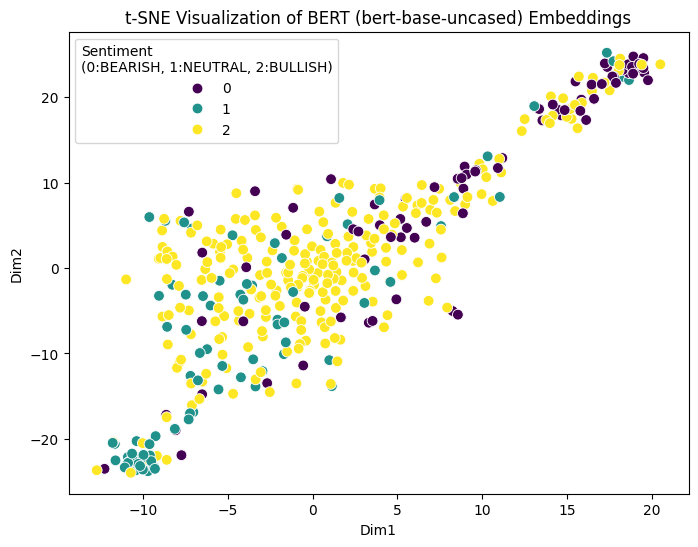

In [25]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
plot_embeddings(embeddings_bert, labels_val, title="t-SNE Visualization of BERT (bert-base-uncased) Embeddings", method="tsne")

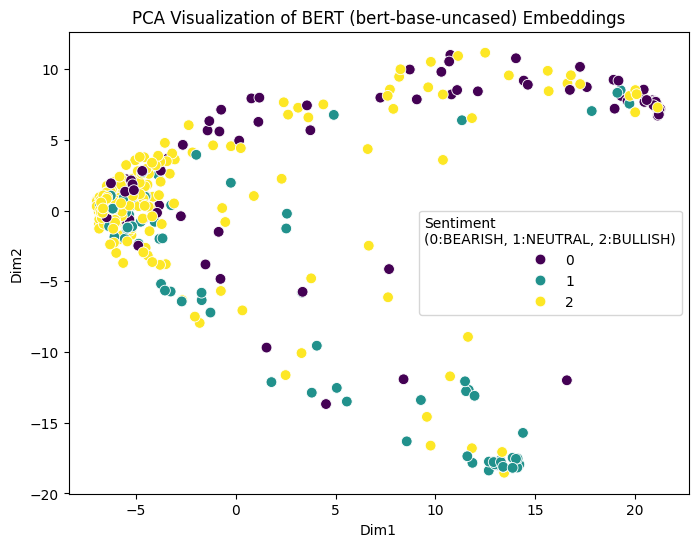

In [26]:
plot_embeddings(embeddings_bert, labels_val, title="PCA Visualization of BERT (bert-base-uncased) Embeddings", method="pca")

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


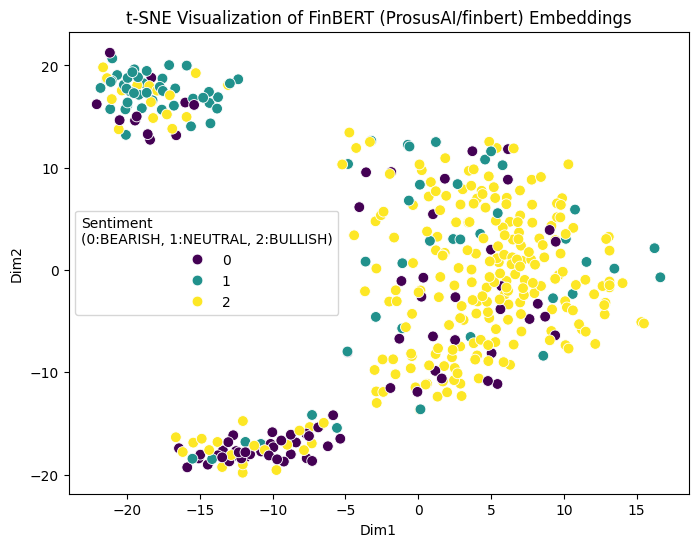

In [27]:
plot_embeddings(embeddings_finbert, labels_val, title="t-SNE Visualization of FinBERT (ProsusAI/finbert) Embeddings", method="tsne")

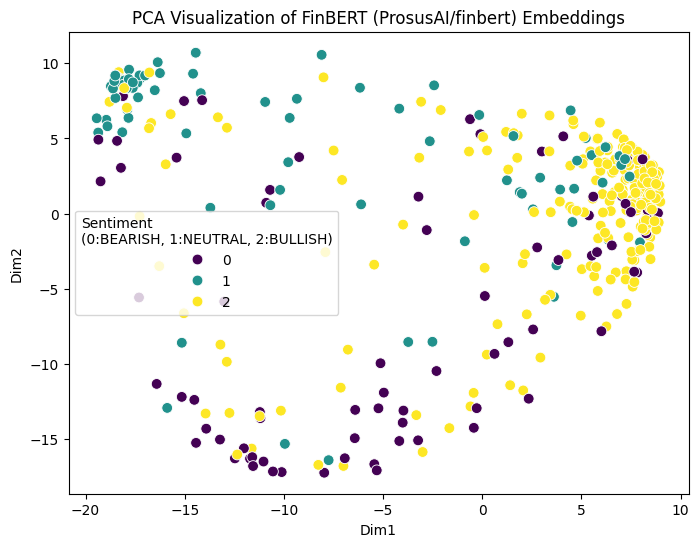

In [28]:
plot_embeddings(embeddings_finbert, labels_val, title="PCA Visualization of FinBERT (ProsusAI/finbert) Embeddings", method="pca")

In [29]:
def get_mean_pool_embeddings(model, tokenizer, texts, max_length=128):
    """
    Generate enhanced embeddings by applying mean pooling over token embeddings.
    """
    model.to(device)
    model.eval()
    embeddings = []
    batch_size = 16
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(batch_texts,
                            padding="max_length",
                            truncation=True,
                            max_length=max_length,
                            return_tensors="pt")
        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True, return_dict=True)
            # Last hidden state: [batch_size, seq_len, hidden_dim]
            last_hidden = outputs.hidden_states[-1]

            # Use the attention mask to compute the average (ignoring padded tokens)
            mask = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
            sum_hidden = torch.sum(last_hidden * mask, dim=1)
            sum_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
            mean_pool = sum_hidden / sum_mask

            embeddings.append(mean_pool.cpu().numpy())
    return np.concatenate(embeddings, axis=0)

In [30]:
def get_aggregated_cls_embeddings(model, tokenizer, texts, max_length=128, num_layers=4):
    """
    Generate enhanced embeddings by aggregating the [CLS] token embeddings from the last 'num_layers' hidden layers.
    """
    model.to(device)
    model.eval()
    embeddings = []
    batch_size = 16
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(batch_texts,
                            padding="max_length",
                            truncation=True,
                            max_length=max_length,
                            return_tensors="pt")
        encoded = {key: val.to(device) for key, val in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded, output_hidden_states=True, return_dict=True)
            # Extract [CLS] token from the last 'num_layers' layers:
            cls_layers = [outputs.hidden_states[-j][:, 0, :] for j in range(1, num_layers+1)]
            aggregated_cls = torch.stack(cls_layers, dim=0).mean(dim=0)
            embeddings.append(aggregated_cls.cpu().numpy())
    return np.concatenate(embeddings, axis=0)

In [31]:
def plot_embeddings(embeddings, labels, title="t-SNE Visualization", method="tsne"):
    """
    Reduce embeddings to two dimensions using t-SNE or PCA and create a scatter plot.
    """
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    elif method == "pca":
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'.")
    reduced = reducer.fit_transform(embeddings)

    # Prepare a DataFrame for plotting
    plot_df = pd.DataFrame({
        "Dim1": reduced[:, 0],
        "Dim2": reduced[:, 1],
        "Label": labels
    })

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=plot_df, x="Dim1", y="Dim2", hue="Label", palette="viridis", s=60)
    plt.title(title)
    plt.legend(title="Sentiment\n(0:BEARISH, 1:NEUTRAL, 2:BULLISH)")
    plt.show()

In [32]:
model_dir = "./finetuned_increased_dropout_10epochs_bert"
tokenizer = BertTokenizerFast.from_pretrained(model_dir)
model = BertForSequenceClassification.from_pretrained(model_dir, num_labels=3)

In [33]:
#BERT

In [34]:
texts_val = val_df['text'].tolist()
labels_val = val_df['label'].tolist()

In [35]:
mean_pool_embeddings = get_mean_pool_embeddings(model, tokenizer, texts_val)
print("Mean pooling embeddings shape:", mean_pool_embeddings.shape)

Mean pooling embeddings shape: (425, 768)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


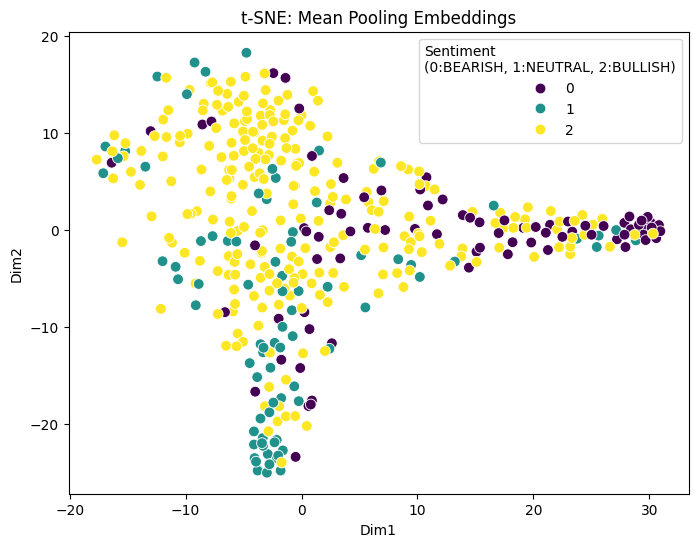

In [36]:
# Plot using t-SNE
plot_embeddings(mean_pool_embeddings, labels_val, title="t-SNE: Mean Pooling Embeddings", method="tsne")

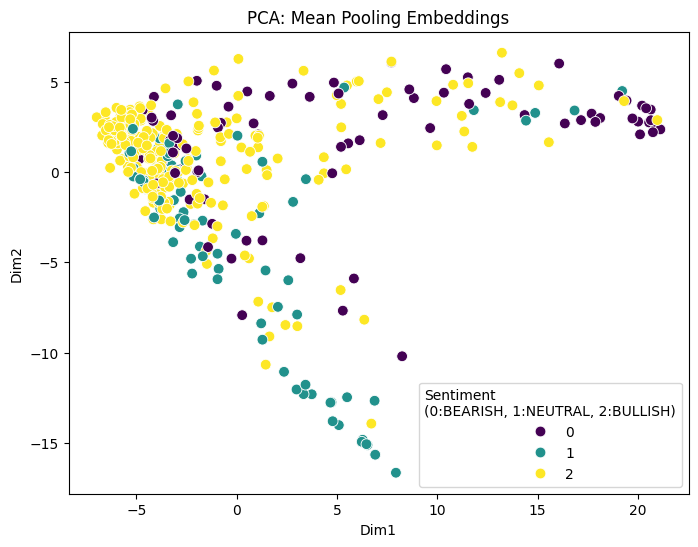

In [37]:
# Plot using PCA
plot_embeddings(mean_pool_embeddings, labels_val, title="PCA: Mean Pooling Embeddings", method="pca")

In [38]:
aggregated_cls_embeddings = get_aggregated_cls_embeddings(model, tokenizer, texts_val, num_layers=4)
print("Aggregated [CLS] embeddings shape:", aggregated_cls_embeddings.shape)

Aggregated [CLS] embeddings shape: (425, 768)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


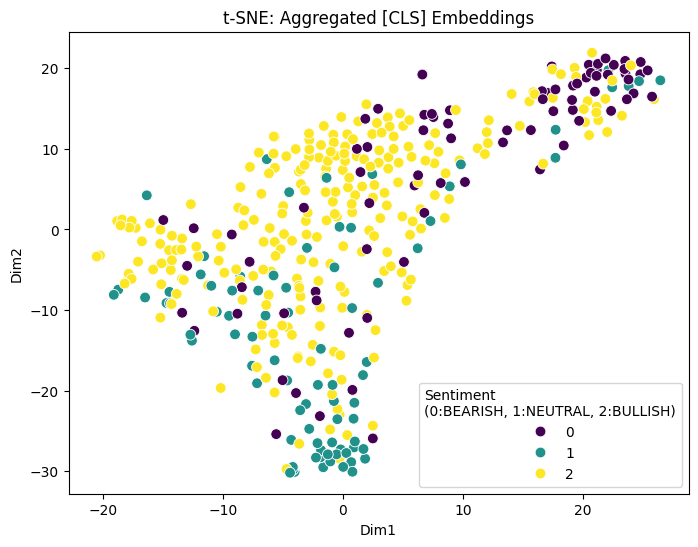

In [39]:
# Plot using t-SNE
plot_embeddings(aggregated_cls_embeddings, labels_val, title="t-SNE: Aggregated [CLS] Embeddings", method="tsne")

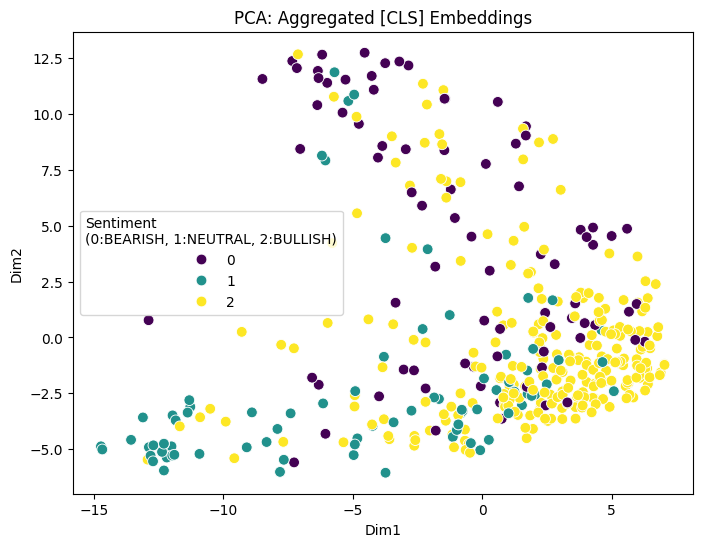

In [40]:
# Plot using PCA
plot_embeddings(aggregated_cls_embeddings, labels_val, title="PCA: Aggregated [CLS] Embeddings", method="pca")

In [41]:
`model_dir = "./finetuned_increased_dropout_10epochs_finbert"
tokenizer = BertTokenizerFast.from_pretrained(model_dir)
model = BertForSequenceClassification.from_pretrained(model_dir, num_labels=3)

In [42]:
mean_pool_embeddings = get_mean_pool_embeddings(model, tokenizer, texts_val)
print("Mean pooling embeddings shape:", mean_pool_embeddings.shape)

Mean pooling embeddings shape: (425, 768)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


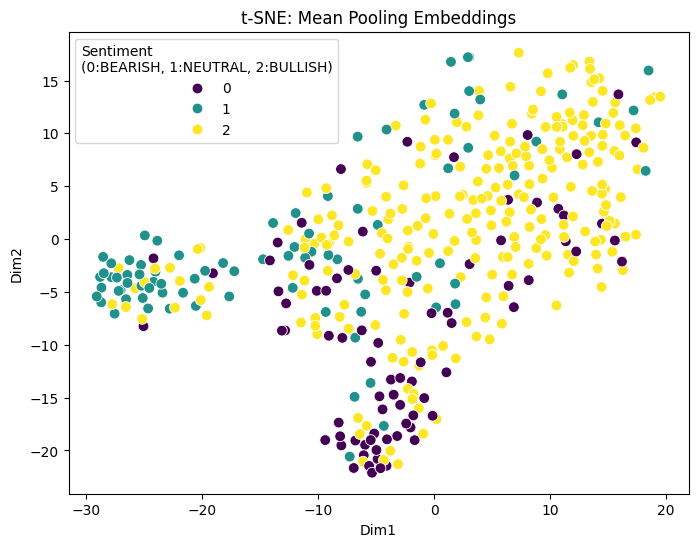

In [43]:
# Plot using t-SNE
plot_embeddings(mean_pool_embeddings, labels_val, title="t-SNE: Mean Pooling Embeddings", method="tsne")

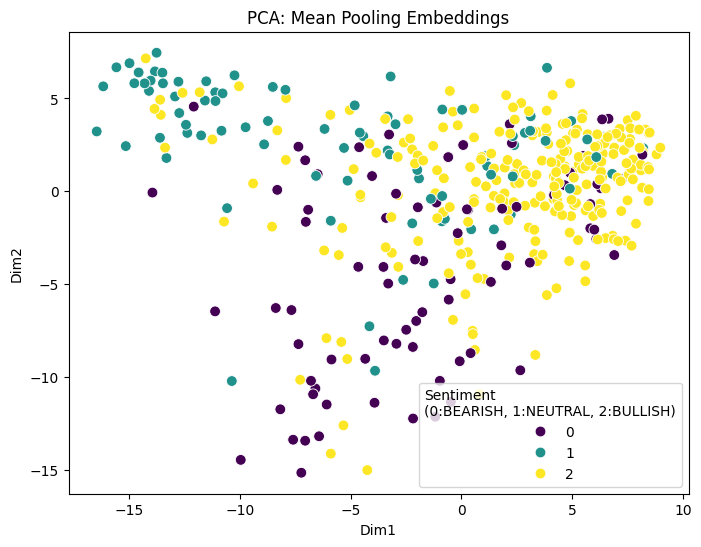

In [44]:
# Plot using PCA
plot_embeddings(mean_pool_embeddings, labels_val, title="PCA: Mean Pooling Embeddings", method="pca")

In [45]:
aggregated_cls_embeddings = get_aggregated_cls_embeddings(model, tokenizer, texts_val, num_layers=4)
print("Aggregated [CLS] embeddings shape:", aggregated_cls_embeddings.shape)

Aggregated [CLS] embeddings shape: (425, 768)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


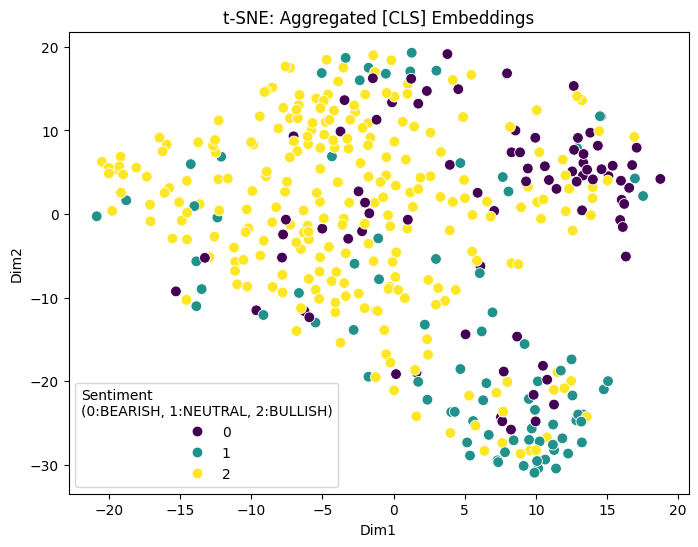

In [46]:
# Plot using t-SNE
plot_embeddings(aggregated_cls_embeddings, labels_val, title="t-SNE: Aggregated [CLS] Embeddings", method="tsne")

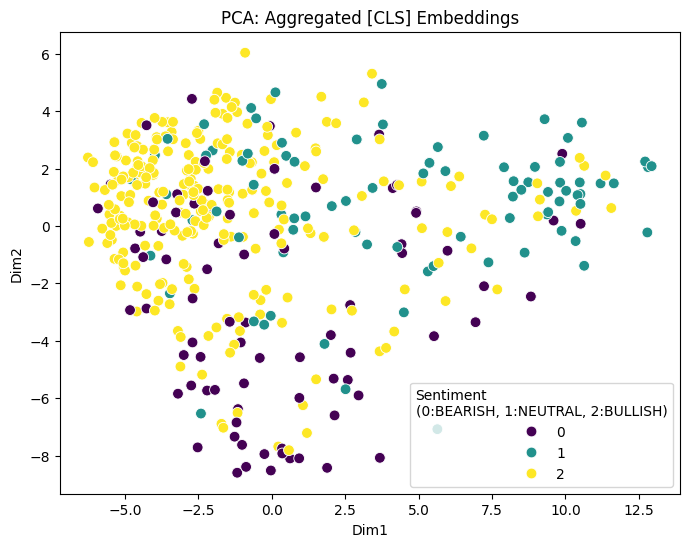

In [47]:
# Plot using PCA
plot_embeddings(aggregated_cls_embeddings, labels_val, title="PCA: Aggregated [CLS] Embeddings", method="pca")

In [ ]:
# summary = result_df.groupby(["Model", "Embedding", "FeatureSet"]).agg({
#     "MAE": "mean",
#     "Accuracy": "mean"
# }).reset_index()
# summary.to_csv(f"{results_dir}/summary_metrics_by_feature.csv", index=False)
# print("✅ Exported summary table to summary_metrics_by_feature.csv")
# print(summary.head())

✅ Exported summary table to summary_metrics_by_feature.csv
   Model Embedding      FeatureSet       MAE  Accuracy
0  DENSE       cls        combined  0.065566  0.538136
1  DENSE       cls      price-only  1.870000  0.478814
2  DENSE       cls  sentiment-only  0.023505  0.580508
3  DENSE       max        combined  0.199142  0.563559
4  DENSE       max      price-only  0.962129  0.542373


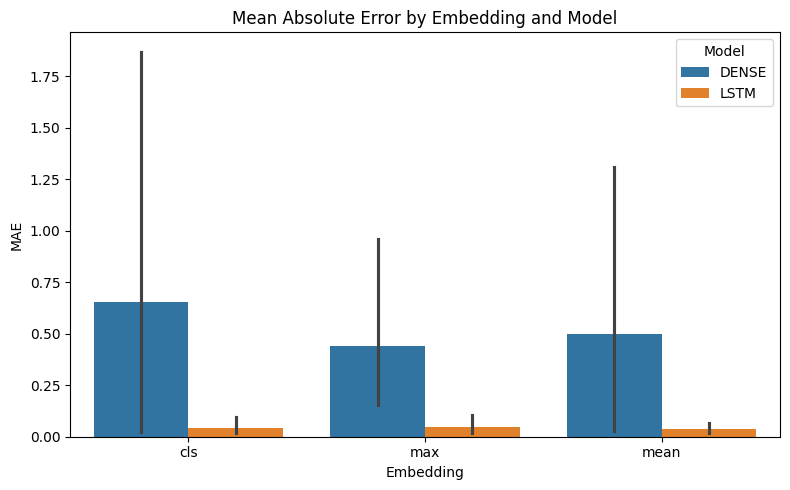

In [ ]:
# plt.figure(figsize=(8, 5))
# sns.barplot(data=summary, x="Embedding", y="MAE", hue="Model")
# plt.title("Mean Absolute Error by Embedding and Model")
# plt.tight_layout()
# plt.savefig(f"{results_dir}/bar_mae.png")
# plt.show()

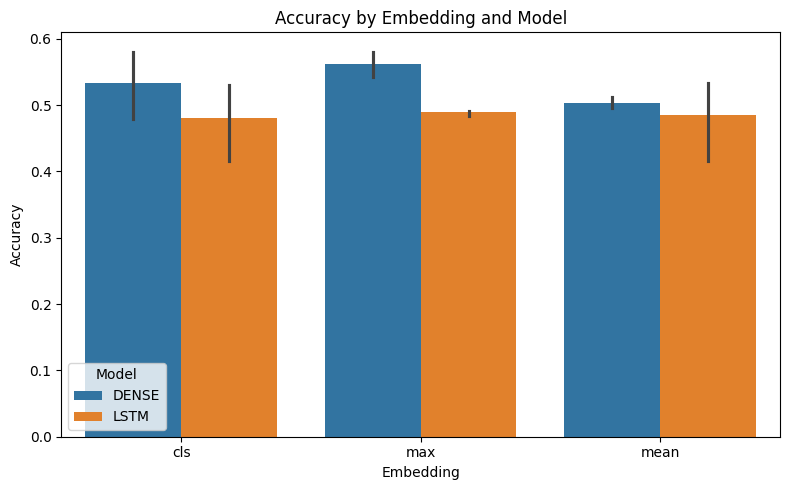

In [ ]:
# plt.figure(figsize=(8, 5))
# sns.barplot(data=summary, x="Embedding", y="Accuracy", hue="Model")
# plt.title("Accuracy by Embedding and Model")
# plt.tight_layout()
# plt.savefig(f"{results_dir}/bar_accuracy.png")
# plt.show()

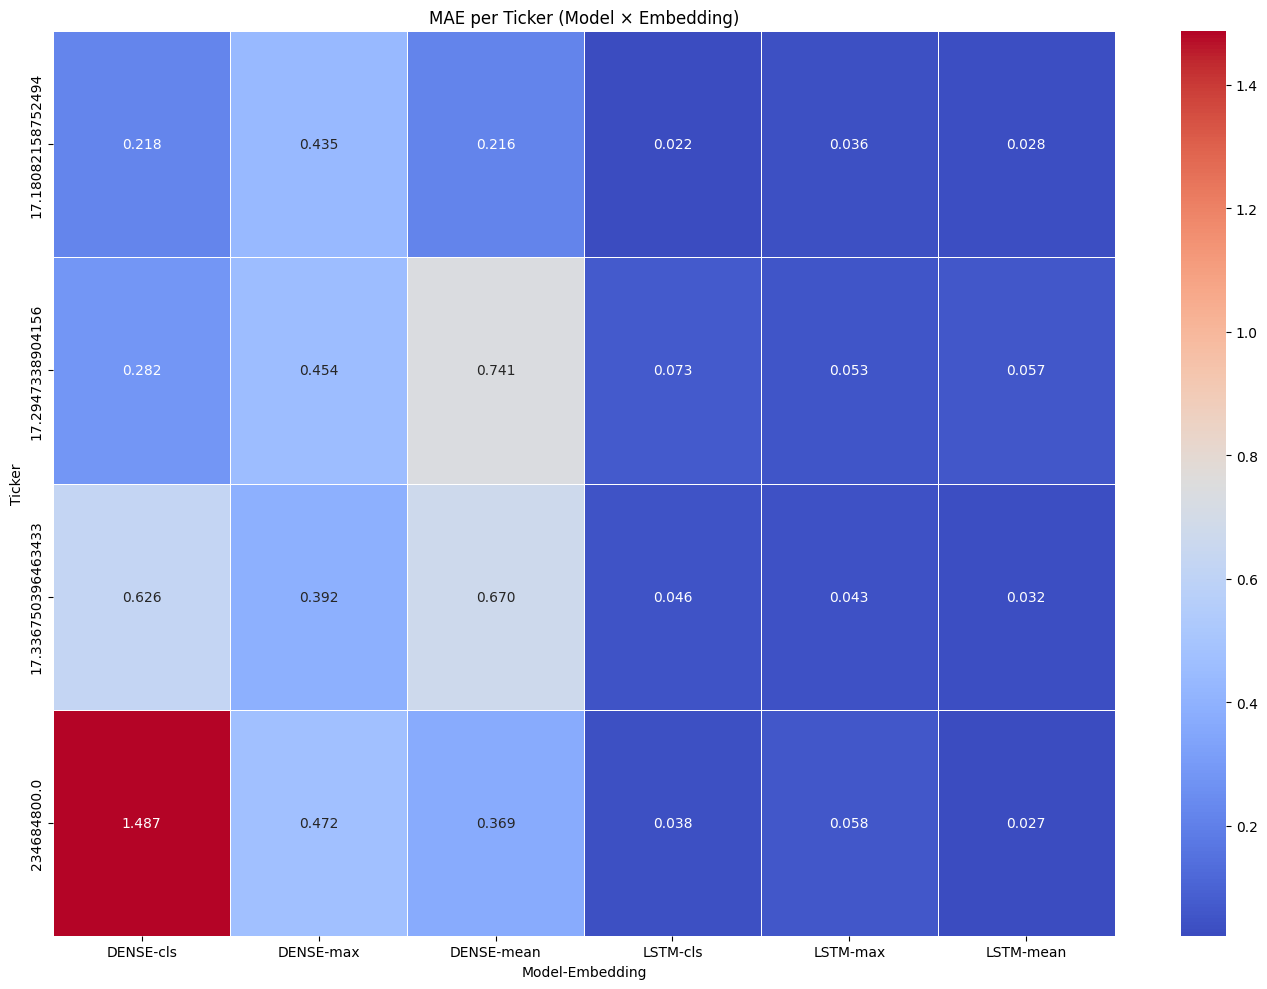

In [ ]:
# heatmap_mae = result_df.pivot_table(index="Ticker", columns=["Model", "Embedding"], values="MAE")
# plt.figure(figsize=(14, 10))
# sns.heatmap(heatmap_mae, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
# plt.title("MAE per Ticker (Model × Embedding)")
# plt.tight_layout()
# plt.savefig(f"{results_dir}/heatmap_mae.png")
# plt.show()

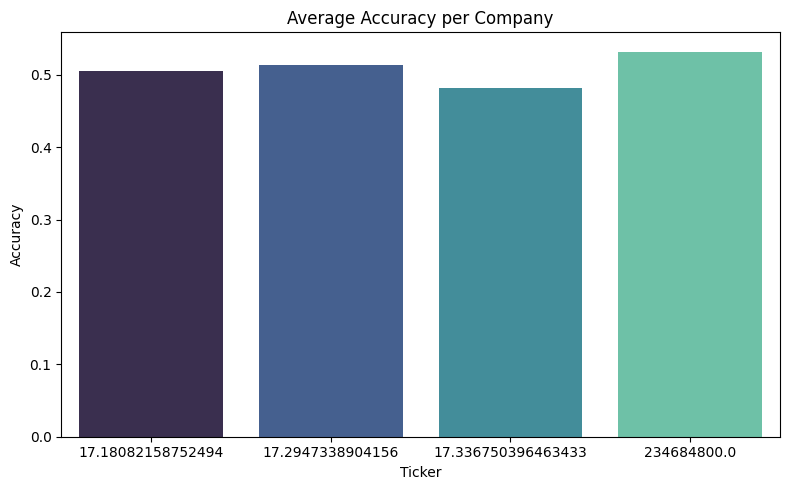

In [ ]:
# company_summary = result_df.groupby("Ticker").agg({
#     "MAE": "mean",
#     "Accuracy": "mean"
# }).reset_index()
# plt.figure(figsize=(8, 5))
# sns.barplot(data=company_summary, x="Ticker", y="Accuracy", palette="mako")
# plt.title("Average Accuracy per Company")
# plt.tight_layout()
# plt.savefig(f"{results_dir}/accuracy_per_company.png")
# plt.show()

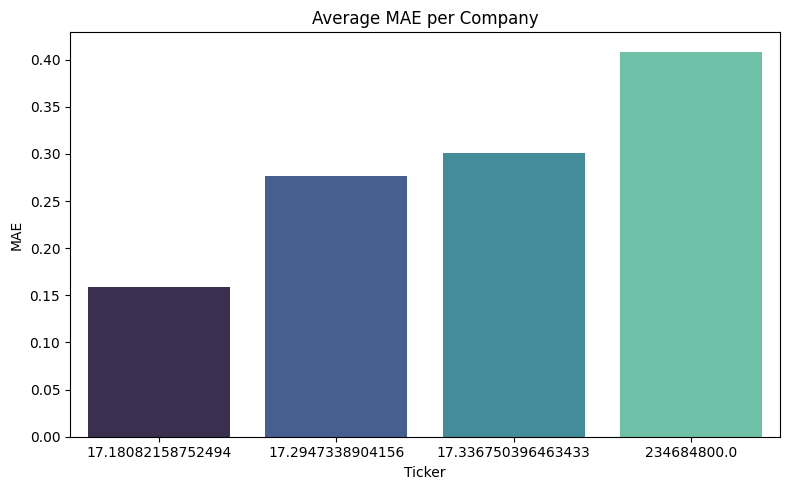

In [ ]:
# plt.figure(figsize=(8, 5))
# sns.barplot(data=company_summary, x="Ticker", y="MAE", palette="mako")
# plt.title("Average MAE per Company")
# plt.tight_layout()
# plt.savefig(f"{results_dir}/mae_per_company.png")
# plt.show()